# State of the States map analysis

Elham Ali (Beeck Center for Social Impact and Innovation at Georgetown University)  
September 30, 2025

This analysis aims to explore trends of digital transformation, specifically on policy, chief data officers, digital service teams, impact reports, and design systems across U.S. states and territories.

## Background

When public climate & EJ evidence disappears (removed, restricted, or altered), a decade of downstream knowledge becomes harder to verify, reproduce, teach, or apply—especially for communities and decisions that most need it.  
This analysis looks at how many studies have used these tools, their topics, and their use cases.

## Questions

Here are the key questions explored in this analysis:

-   How many **states/territories** have at least one:

    -   Executive order
    -   AI Legislation
    -   Chief Data Officer (CDO)
    -   Digital Service Team (DST)
    -   Digital Service Impact Report
    -   Design system

-   Which states are the **most active vs. least active** across all categories?

-   Which states introduced **CDOs or DSTs earliest**, and how has that spread across regions?

-   Which states with **active CDOs** also have **design systems** or **DSTs**?

-   Are states with **AI legislation** more likely to have other forms of digital infrastructure (DST, design systems)?

-   In which region(s) do **AI legislation policies cluster** in?

-   What are the **most common policy topics** in executive orders (e.g., broadband, interoperability, AI)?

-   What are the **most common policy topics** in AI legislations orders (e.g., broadband, interoperability, AI)?

-   What is the **trend over time** in the number of executive orders and AI legislations enacted?

-   Do **early adopters** (states with policies from 2010–2015) differ from **late adopters** in 2020–2025?

-   Do certain AI legislation topics **cluster in certain regions**? Do certain executive topics topics cluster in certain regions?

## Data Sources

The climate tools assessed are:

-   map_data
-   policy_data

The data for this project comes from the Digital Service Network at the Beeck and last refreshed on September 30, 2025.

Original raw datasets are saved in the `data/` folder. This script reduces and cleans those datasets to prepare them for analysis.

------------------------------------------------------------------------

## Cleaning

I start by loading the packages needed for file handling, data wrangling, and visualization.

In [ ]:
## Folder structure helpers
library(here)

here() starts at /Users/elhamali/Documents/Data Projects/state-of-states-map-analysis

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'janitor'

The following objects are masked from 'package:stats':

    chisq.test, fisher.test

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'igraph'

The following objects are masked from 'package:lubridate':

    %--%, union

The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union

The following objects are masked from 'package:purrr':

    compose, simplify

The following object is masked from 'package:tidyr':

    crossing

The following object is masked from 'package:tibble':

    as_data_frame

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

### Import raw data

I import all .csv files from the `data/` folder, then save them as .rds files into `output/`. This preserves their structure and speeds up future reads.

In [ ]:
# List all CSV files
csv_files <- list.files(here("data"), pattern = "\\.csv$", full.names = TRUE)

# Read into a list of dataframes
datasets <- map(csv_files, read.csv)
names(datasets) <- tools::file_path_sans_ext(basename(csv_files))

# Save each dataset as .rds in output/
walk2(
  datasets,
  names(datasets),
  ~ saveRDS(.x, here("output", paste0(.y, ".rds")))
)

### Clean both datasets

I apply the same cleaning process to both datasets (map_data and policy_data):

-   Standardize variable names to snake_case
-   Guess variable types (integers, doubles, dates, etc.)
-   Convert responses for ‘executive_orders’, ‘ai_legislations’, ‘digital_service_teams’, ‘digital_service_impact_reports’
    -   yes to 1
    -   no to 0
-   Convert responses for ‘design_systems’
    -   yes to 1
    -   in development to 1
    -   no to 0
    -   unverified to 0
-   Convert responses for ‘chief_data_officers’
    -   yes, state CDO to 1
    -   yes, state CDO equivalent to 1
    -   no to 0
    -   no, vacant to 0
    -   unverified to 0
-   Add a region variable to classify the state’s based on CDC’s four regions [1]
    -   **Northeast**: Includes Connecticut, Maine, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Rhode Island, and Vermont
    -   **Midwest**: Includes Illinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Missouri, Nebraska, North Dakota, Ohio, South Dakota, and Wisconsin
    -   **South**: Includes Alabama, Arkansas, Delaware, District of Columbia, Florida, Georgia, Kentucky, Louisiana, Maryland, Mississippi, North Carolina, Oklahoma, South Carolina, Tennessee, Texas, Virginia, and West Virginia
    -   **West**: Includes Alaska, Arizona, California, Colorado, Hawaii, Idaho, Montana, Nevada, New Mexico, Oregon, Utah, Washington, and Wyoming.
    -   **Territories**: Includes American Samoa, Guam, the Northern Mariana Islands, Puerto Rico, and the U.S. Virgin Islands (not included in CDC’s regional mapping, but I added here to include the territories)

[1] <https://www.cdc.gov/nchs/hus/sources-definitions/geographic-region.htm>

In [ ]:
# -------------------------------------------------------------------
# Libraries
library(here)
library(tidyverse)   # includes dplyr, stringr, readr, etc.
library(janitor)
library(lubridate)
library(forcats)
library(glue)
library(fs)


Attaching package: 'fs'

The following object is masked from 'package:igraph':

    path

I’ll now assign the right variable types for the cleaned datasets.

In [ ]:
library(dplyr)
library(stringr)
library(readr)
library(forcats)

# load inputs created earlier
map_data_clean    <- readr::read_rds(here("output", "map_data_clean.rds"))
policy_data_clean <- readr::read_rds(here("output", "policy_data_clean.rds"))

to_binary <- function(x) {
  if (is.logical(x)) return(as.integer(x))
  if (is.numeric(x)) return(as.integer(x == 1))
  x_chr <- tolower(trimws(as.character(x)))
  x_chr[x_chr == ""] <- NA
  yes_vals <- c("yes","y","true","t","1","present","has","active","in development")
  no_vals  <- c("no","n","false","f","0","absent","none","inactive","unverified","no, vacant")
  as.integer(dplyr::case_when(
    x_chr %in% yes_vals ~ 1L,
    x_chr %in% no_vals  ~ 0L,
    TRUE ~ NA_integer_
  ))
}

to_region_factor <- function(x) {
  # map region labels to codes 1..5
  ref <- c("Northeast","Midwest","South","West","Territories")
  idx <- match(as.character(x), ref)          # NA if label not in ref
  factor(as.character(idx), levels = as.character(seq_along(ref)), ordered = TRUE)
}

# ---------- map_data_clean ----------
map_int_cols <- c(
  "total_number_of_executive_orders",
  "total_number_of_legislation",
  "total_number_of_administrative_rules",
  "publication_year"
)
map_dbl_cols <- c("cdo_year_established")
map_bin_cols <- c(
  "executive_orders","ai_legislations","administrative_rules",
  "digital_service_teams","digital_service_impact_reports",
  "chief_data_officers","design_systems","design_system_open_source_status"
)
map_cat_cols <- c("bill_status")

map_data_clean <- map_data_clean %>%
  mutate(across(everything(), ~ as.character(.))) %>%
  mutate(
    across(any_of(map_int_cols), ~ suppressWarnings(as.integer(readr::parse_number(.)))),
    across(any_of(map_dbl_cols), ~ suppressWarnings(as.double(readr::parse_number(.)))),
    across(any_of(map_bin_cols), to_binary),
    across(any_of(map_cat_cols), ~ forcats::as_factor(trimws(.))),
    region = to_region_factor(region)
  )

# ---------- policy_data_clean ----------
pol_int_cols <- c("executive_order_year_enacted", "legislative_session")
pol_cat_cols <- c("scan_type", "bill_status")

policy_data_clean <- policy_data_clean %>%
  mutate(across(everything(), ~ as.character(.))) %>%
  mutate(
    across(any_of(pol_int_cols), ~ suppressWarnings(as.integer(readr::parse_number(.)))),
    across(any_of(pol_cat_cols), ~ forcats::as_factor(trimws(.))),
    region = to_region_factor(region)
  )

## Analysis

I will look at each question one by one and clean the data as I go. I will organize the data during the analysis before exploring the results. I’ll also export intermediate results into tidy CSV files so they are ready for further visualization and exploration.

### Q1

-   How many **states/territories** have at least one:

    -   Executive order
    -   AI Legislation
    -   Chief Data Officer (CDO)
    -   Digital Service Team (DST)
    -   Digital Service Impact Report
    -   Design system


Attaching package: 'scales'

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor

file:////Users/elhamali/Documents/Data Projects/state-of-states-map-analysis/output/q1.html screenshot completed

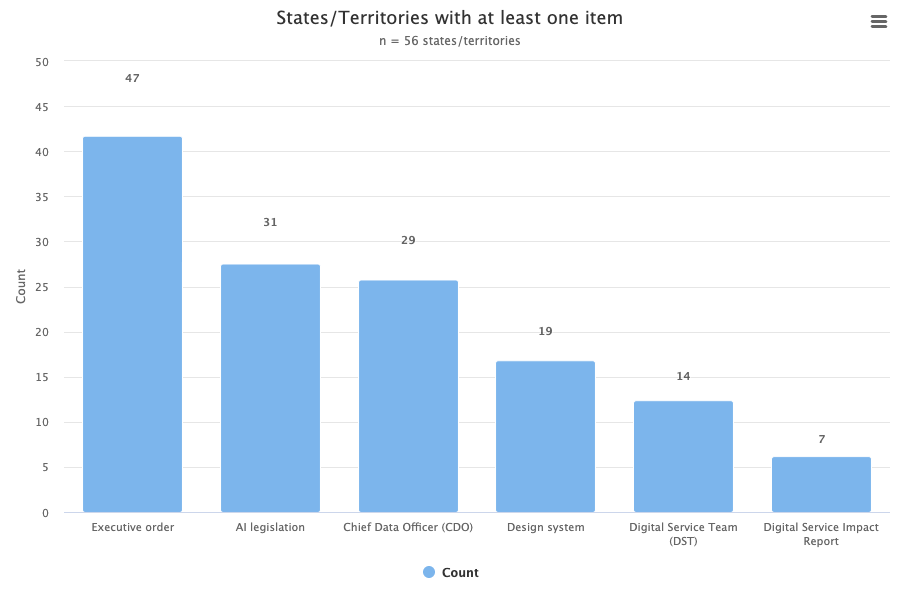

83.9% U.S. states/territories have an executive order.
55.4% U.S. states/territories have AI legislation.
51.8% U.S. states/territories have a chief data office (CDO).
33.9% U.S. states/territories have a design system.
25.0% U.S. states/territories have a digital service team (DST).
12.5% U.S. states/territories have a digital service impact report.

In [ ]:
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# Packages
library(tidyverse)
library(highcharter)
library(htmlwidgets)
library(webshot2)
library(glue)
library(scales)

### Q2

-   Which **regions** have the most vs least:

    -   Executive order

    -   AI Legislations

    -   Chief Data Officers (CDO)

    -   Digital Service Teams (DST)

    -   Digital Service Impact Reports

    -   Design systems

I grouped states and territories into CDC regions and flagged whether each had an executive order, AI legislation, a Chief Data Officer (CDO), a Digital Service Team (DST), a Digital Service Impact Report, or a design system. I then summed counts within each region to identify where adoption was highest and lowest.

In [ ]:
library(readr); library(here)
library(dplyr); library(tidyr); library(purrr)
library(glue)

map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# Indicators
indicators <- c(
  executive_orders                = "Executive order",
  ai_legislations                 = "AI legislation",
  chief_data_officers             = "Chief Data Officer (CDO)",
  digital_service_teams           = "Digital Service Team (DST)",
  digital_service_impact_reports  = "Digital Service Impact Report",
  design_systems                  = "Design system"
)

region_order <- c("Northeast","Midwest","South","West","Territories")

# Prep: one row per state, coerce to logical
map_prepped <- map_data_clean %>%
  distinct(state_territory, .keep_all = TRUE) %>%
  filter(!is.na(region)) %>%
  mutate(region = factor(region, levels = region_order)) %>%
  mutate(across(any_of(names(indicators)),
                ~ dplyr::coalesce(. == 1L | . == TRUE, FALSE)))

# Counts by region & indicator
region_counts <- map_prepped %>%
  select(region, any_of(names(indicators))) %>%
  pivot_longer(-region, names_to = "indicator", values_to = "has_it") %>%
  group_by(region, indicator) %>%
  summarise(count = sum(has_it, na.rm = TRUE), .groups = "drop") %>%
  mutate(label = recode(indicator, !!!indicators)) %>%
  arrange(label, region)

# Find most/least per indicator
most_tbl <- region_counts %>%
  group_by(indicator) %>%
  slice_max(count, with_ties = TRUE) %>%
  ungroup() %>%
  mutate(which = "most")

least_tbl <- region_counts %>%
  group_by(indicator) %>%
  slice_min(count, with_ties = TRUE) %>%
  ungroup() %>%
  mutate(which = "least")

# Build sentences
pretty_regions <- function(x) paste(x, collapse = ", ")
mk_sentence <- function(rows, which, obj) {
  regs <- pretty_regions(rows$region)
  glue("{regs} has the {which} {obj}.")
}

insights_q2 <- tibble(indicator = unique(region_counts$indicator)) %>%
  mutate(
    label = recode(indicator, !!!indicators),
    statement = map_chr(indicator, \(ind) {
      most  <- filter(most_tbl,  indicator == ind)
      least <- filter(least_tbl, indicator == ind)
      paste(
        mk_sentence(most, "most",  recode(ind, !!!indicators)),
        mk_sentence(least, "least", recode(ind, !!!indicators))
      )
    })
  ) %>%
  select(label, statement)

# Save both outputs
write_csv(region_counts, here("output", "region_counts_q2.csv"))
write_csv(insights_q2,  here("output", "insights_q2.csv"))

# Print results in document
# region_counts
insights_q2

# A tibble: 6 × 2
  label                         statement                                       
  <chr>                         <chr>                                           
1 AI legislation                South has the most AI legislation. Territories …
2 Chief Data Officer (CDO)      South, West has the most Chief Data Officer (CD…
3 Design system                 Northeast, South has the most Design system. Te…
4 Digital Service Impact Report Northeast has the most Digital Service Impact R…
5 Digital Service Team (DST)    Northeast has the most Digital Service Team (DS…
6 Executive order               South has the most Executive order. Territories…

### Q3

-   Which states are the **most active vs. least active** across all categories?

To measure overall state activity, I created a six-item score where states received one point for the presence of each digital activity (executive orders, AI legislation, CDO, DST, Digital Service Impact Report, design system). Each state’s score ranged from 0–6 to indicate the breadth of digital transformation. I then ranked states by total score and identified the most and least active states.

In [ ]:
library(readr); library(here)
library(dplyr); library(tidyr); library(purrr); library(glue)

# 1) Load
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# 2) Columns (names = dataset column names; values = friendly labels)
act_labels <- c(
  executive_orders               = "Executive orders",
  ai_legislations                = "AI legislations",
  chief_data_officers            = "Chief Data Officers (CDO)",
  digital_service_teams          = "Digital Service Teams (DST)",
  digital_service_impact_reports = "Digital Service Impact Reports",
  design_systems                 = "Design systems"
)

# 3) Presence (0/1) per category, score out of 6 (one row per state)
state_counts_q3 <- map_data_clean %>%
  distinct(state_territory, .keep_all = TRUE) %>%
  transmute(
    state_territory,
    across(
      all_of(names(act_labels)),
      ~ as.integer(dplyr::coalesce(. >= 1L, FALSE))
    )
  ) %>%
  mutate(
    activity_score = rowSums(across(all_of(names(act_labels)))),
    categories_present = pmap_chr(
      across(all_of(names(act_labels))),
      ~ {
        vals <- c(...)
        labs <- act_labels[vals == 1]
        if (length(labs) == 0) "None" else paste(labs, collapse = ", ")
      }
    )
  ) %>%
  arrange(desc(activity_score), state_territory)

# 4) Full ranks (for later viz)
state_ranks_q3 <- state_counts_q3 %>%
  mutate(
    rank_desc = min_rank(desc(activity_score)),  # 1 = most active
    rank_asc  = min_rank(activity_score)        # 1 = least active
  ) %>%
  arrange(rank_desc, state_territory)

# 5) Top/bottom 10 (ties included at the cutoff)
top10 <- state_ranks_q3 %>% filter(rank_desc <= 10)
bot10 <- state_ranks_q3 %>% filter(rank_asc  <= 10)

fmt_list <- function(df) paste0(df$state_territory, " (", df$activity_score, "/6)", collapse = "; ")

insights_q3 <- tibble(
  type = c("Most active (top 10; ties included)", "Least active (bottom 10; ties included)"),
  statement = c(fmt_list(top10), fmt_list(bot10))
)

# 6) Save (match Q2 naming pattern: *_q3.csv) -------------------------------
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(state_counts_q3, here("output", "state_counts_q3.csv"))
write_csv(insights_q3,     here("output", "insights_q3.csv"))
write_csv(state_ranks_q3,  here("output", "state_ranks_q3.csv"))

# 7) Print in document (same pattern as Q2)
# state_counts_q3
insights_q3

# A tibble: 2 × 2
  type                                    statement                             
  <chr>                                   <chr>                                 
1 Most active (top 10; ties included)     California (6/6); Colorado (6/6); Mas…
2 Least active (bottom 10; ties included) Alabama (1/6); Alaska (1/6); American…

### Q4

-   Which states introduced **CDOs or DSTs earliest**, and how has that spread across regions?

For CDOs, I filtered to states with an active CDO and recorded the year the office was established. I then identified the earliest and most recent adopters. For DSTs, I imported a separate dataset of team founding years and names, cleaned it, and identified the earliest and latest established teams.

In [ ]:
library(readr); library(here)
library(dplyr); library(glue)

# -------------------------------------------------------------------
# 1) Load map_data_clean
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# -------------------------------------------------------------------
# 2) Import and clean dst_data.csv -> dst_data_clean
dst_data_clean <- read_csv(here("data", "dst_data.csv"),
                           show_col_types = FALSE) %>%
  mutate(
    team_year_founded = as.integer(team_year_founded),
    state_territory   = as.character(state_territory),
    team_name         = as.character(team_name)
  )

# Save cleaned DST data
write_rds(dst_data_clean, here("output", "dst_data_clean.rds"))
write_csv(dst_data_clean, here("output", "dst_data_clean.csv"))

# -------------------------------------------------------------------
# 3) CDO analysis
cdo_tbl <- map_data_clean %>%
  distinct(state_territory, .keep_all = TRUE) %>%
  filter(!is.na(cdo_year_established) & chief_data_officers >= 1) %>%
  transmute(state_territory, cdo_year_established)

earliest_cdo <- cdo_tbl %>%
  filter(cdo_year_established == min(cdo_year_established, na.rm = TRUE))
latest_cdo <- cdo_tbl %>%
  filter(cdo_year_established == max(cdo_year_established, na.rm = TRUE))

insights_cdo <- tibble(
  statement = c(
    glue("{earliest_cdo$state_territory} introduced CDOs earliest in {earliest_cdo$cdo_year_established}."),
    glue("{latest_cdo$state_territory} introduced CDOs the latest in {latest_cdo$cdo_year_established}.")
  )
)

# -------------------------------------------------------------------
# 4) DST analysis
dst_tbl <- dst_data_clean %>%
  filter(!is.na(team_year_founded)) %>%
  arrange(team_year_founded)

earliest_dst <- dst_tbl %>%
  filter(team_year_founded == min(team_year_founded, na.rm = TRUE))
latest_dst <- dst_tbl %>%
  filter(team_year_founded == max(team_year_founded, na.rm = TRUE))

insights_dst <- tibble(
  statement = c(
    glue("{earliest_dst$state_territory} introduced its Digital Service Team ({earliest_dst$team_name}) earliest in {earliest_dst$team_year_founded}."),
    glue("{latest_dst$state_territory} introduced its Digital Service Team ({latest_dst$team_name}) the latest in {latest_dst$team_year_founded}.")
  )
)

# -------------------------------------------------------------------
# 5) Save outputs
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)

write_csv(cdo_tbl,      here("output", "cdo_years_q4.csv"))
write_csv(insights_cdo, here("output", "insights_cdo_q4.csv"))

write_csv(dst_tbl,      here("output", "dst_years_q4.csv"))
write_csv(insights_dst, here("output", "insights_dst_q4.csv"))

# -------------------------------------------------------------------
# 6) Print in document
cdo_tbl

        state_territory cdo_year_established
1               Arizona                 2024
2              Arkansas                 2017
3            California                 2019
4              Colorado                 2010
5           Connecticut                 2014
6              Delaware                 2018
7  District of Columbia                 2017
8               Florida                 2017
9                Hawaii                 2022
10              Indiana                 2017
11               Kansas                 2024
12                Maine                 2018
13             Maryland                 2021
14        Massachusetts                 2016
15             Michigan                 2023
16             Missouri                 2023
17              Montana                 2021
18               Nevada                 2024
19           New Jersey                 2015
20       North Carolina                 2016
21         North Dakota                 2018
22        

# A tibble: 5 × 1
  statement                                       
  <chr>                                           
1 Colorado introduced CDOs earliest in 2010.      
2 Arizona introduced CDOs the latest in 2024.     
3 Kansas introduced CDOs the latest in 2024.      
4 Nevada introduced CDOs the latest in 2024.      
5 Rhode Island introduced CDOs the latest in 2024.

# A tibble: 15 × 6
   state_territory team_name            team_year_founded team_location_in_org…¹
   <chr>           <chr>                            <int> <chr>                 
 1 Delaware        Delaware Government…              2001 Department of State   
 2 New York        New York State Digi…              2013 Office of General Ser…
 3 Rhode Island    Rhode Island Enterp…              2013 Department of Adminis…
 4 North Carolina  North Carolina Digi…              2015 Department of Informa…
 5 Massachusetts   Massachusetts Digit…              2017 Executive Office of T…
 6 Vermont         Vermont Agency of D…              2017 Governor's Office     
 7 New Jersey      New Jersey Office o…              2018 External nonprofit    
 8 Colorado        Colorado Digital Se…              2019 The Governor's Office…
 9 Connecticut     Connecticut Digital…              2019 Department of Adminis…
10 California      California Office o…              2019 Government Operations…
11 Colora

# A tibble: 4 × 1
  statement                                                                     
  <chr>                                                                         
1 Delaware introduced its Digital Service Team (Delaware Government Information…
2 Arizona introduced its Digital Service Team (Arizona Digital Solutions Office…
3 Maryland introduced its Digital Service Team (Maryland Digital Service (MDDS)…
4 Minnesota introduced its Digital Service Team (Minnesota Digital Services, An…

### Q5

-   Which states with **active CDOs** also have **design systems** or **DSTs**?

I examined whether states with CDOs also adopted other infrastructure (design systems or DSTs). After filtering to states with active CDOs, I tallied how many also had design systems or DSTs. I then compared the likelihood of having a DST between states with and without CDOs using a relative likelihood ratio.

In [ ]:
library(readr); library(here)
library(dplyr); library(glue)

# -------------------------------------------------------------------
# 1) Load cleaned dataset
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# -------------------------------------------------------------------
# 2) Prep: keep one row per state/territory, coerce presence to 0/1
q5_tbl <- map_data_clean %>%
  distinct(state_territory, .keep_all = TRUE) %>%
  transmute(
    state_territory,
    cdo    = as.integer(coalesce(chief_data_officers,        0L) >= 1L),
    design = as.integer(coalesce(design_systems,             0L) >= 1L),
    dst    = as.integer(coalesce(digital_service_teams,      0L) >= 1L)
  )

# -------------------------------------------------------------------
# 3) Which states with active CDOs also have design systems or DSTs?
cdo_active <- q5_tbl %>% filter(cdo == 1)

cdo_with_design_or_dst <- cdo_active %>%
  filter(design == 1 | dst == 1)

num_states <- nrow(cdo_with_design_or_dst)
state_names <- paste(cdo_with_design_or_dst$state_territory, collapse = ", ")

# -------------------------------------------------------------------
# 4) Likelihood comparison: probability of DST with CDO vs. without
p_dst_with_cdo <- mean(cdo_active$dst == 1, na.rm = TRUE)
p_dst_without  <- mean(q5_tbl %>% filter(cdo == 0) %>% pull(dst) == 1, na.rm = TRUE)

likelihood_ratio <- ifelse(p_dst_without > 0, p_dst_with_cdo / p_dst_without, NA_real_)

# Round ratio nicely (e.g., 2.2x more likely)
ratio_text <- ifelse(is.na(likelihood_ratio), "undefined",
                     paste0(round(likelihood_ratio, 1), "x more"))

# -------------------------------------------------------------------
# 5) Build insight statements
insights_q5 <- tibble(
  statement = c(
    glue("{num_states} states with active CDOs also have design systems or DSTs. They are {state_names}."),
    glue("States with Chief Data Officers are {ratio_text} likely to have digital service teams.")
  )
)

# -------------------------------------------------------------------
# 6) Save outputs
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(q5_tbl,        here("output", "state_counts_q5.csv"))
write_csv(insights_q5,   here("output", "insights_q5.csv"))

# -------------------------------------------------------------------
# 7) Print results
q5_tbl

            state_territory cdo design dst
1                   Alabama   0      0   0
2                    Alaska   0      0   0
3            American Samoa   0      0   0
4                   Arizona   1      0   1
5                  Arkansas   1      0   0
6                California   1      1   1
7                  Colorado   1      1   1
8               Connecticut   1      1   1
9                  Delaware   1      1   1
10     District of Columbia   1      0   0
11                  Florida   1      0   0
12                  Georgia   0      1   0
13                     Guam   0      0   0
14                   Hawaii   1      0   0
15                    Idaho   0      0   0
16                 Illinois   0      1   0
17                  Indiana   1      0   0
18                     Iowa   0      1   0
19                   Kansas   1      0   0
20                 Kentucky   0      0   0
21                Louisiana   0      1   0
22                    Maine   1      0   0
23         

# A tibble: 2 × 1
  statement                                                                     
  <chr>                                                                         
1 13 states with active CDOs also have design systems or DSTs. They are Arizona…
2 States with Chief Data Officers are 3.4x more likely to have digital service …

### Q6

-   Are states with **AI legislation** more likely to have other forms of digital infrastructure (DST, design systems)?

I defined “digital infrastructure” broadly as the presence of any of the following: a CDO, DST, Digital Service Impact Report, or design system. I then compared the probability of having this infrastructure between states with versus without executive orders, AI legislation, or any policy (executive order or AI). Likelihood ratios were calculated to quantify differences, and notable examples were listed.

In [ ]:
library(readr); library(here)
library(dplyr); library(glue)

# Load
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# Prep (one row/state; presence 0/1)
q6_tbl <- map_data_clean %>%
  distinct(state_territory, .keep_all = TRUE) %>%
  transmute(
    state_territory,
    eo     = as.integer(coalesce(executive_orders,          0L) >= 1L),
    ai     = as.integer(coalesce(ai_legislations,           0L) >= 1L),
    cdo    = as.integer(coalesce(chief_data_officers,       0L) >= 1L),
    dst    = as.integer(coalesce(digital_service_teams,     0L) >= 1L),
    dsir   = as.integer(coalesce(digital_service_impact_reports, 0L) >= 1L),
    design = as.integer(coalesce(design_systems,            0L) >= 1L)
  ) %>%
  mutate(
    # DEFINITION NOTE:
    # "Digital infrastructure" = present if ANY of the following are present:
    #   CDO OR Digital Service Team (DST) OR Digital Service Impact Report (DSIR) OR Design system
    infra = as.integer(cdo == 1 | dst == 1 | dsir == 1 | design == 1),
    any_policy = as.integer(eo == 1 | ai == 1)
  )

# Helper: ratio + notable examples
calc_ratio <- function(df, policy_col) {
  with_policy    <- df %>% filter(.data[[policy_col]] == 1)
  without_policy <- df %>% filter(.data[[policy_col]] == 0)

  p_with    <- mean(with_policy$infra == 1, na.rm = TRUE)
  p_without <- mean(without_policy$infra == 1, na.rm = TRUE)

  ratio <- ifelse(p_without > 0, p_with / p_without, NA_real_)
  ratio_text <- ifelse(is.na(ratio), "undefined", paste0(round(ratio, 1), "x more"))

  notable <- with_policy %>% filter(infra == 1) %>% pull(state_territory)
  notable_text <- ifelse(length(notable) > 0, paste(notable, collapse = ", "), "None")

  list(ratio_text = ratio_text, notable_text = notable_text)
}

# Ratios + statements
eo_stats  <- calc_ratio(q6_tbl, "eo")
ai_stats  <- calc_ratio(q6_tbl, "ai")
any_stats <- calc_ratio(q6_tbl, "any_policy")

insights_q6 <- tibble(
  statement = c(
    glue("States with executive orders are {eo_stats$ratio_text} likely to have other forms of digital infrastructure (CDO, DST, Digital Service Impact Report, design system). Notable examples are {eo_stats$notable_text}."),
    glue("States with AI legislation are {ai_stats$ratio_text} likely to have other forms of digital infrastructure (CDO, DST, Digital Service Impact Report, design system). Notable examples are {ai_stats$notable_text}."),
    glue("States with any policy (AI legislation and/or executive orders) are {any_stats$ratio_text} likely to have other forms of digital infrastructure (CDO, DST, Digital Service Impact Report, design system). Notable examples are {any_stats$notable_text}.")
  )
)

# Save outputs
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(q6_tbl,      here("output", "state_counts_q6.csv"))
write_csv(insights_q6, here("output", "insights_q6.csv"))

# Print results
q6_tbl

            state_territory eo ai cdo dst dsir design infra any_policy
1                   Alabama  1  0   0   0    0      0     0          1
2                    Alaska  1  0   0   0    0      0     0          1
3            American Samoa  1  0   0   0    0      0     0          1
4                   Arizona  0  1   1   1    0      0     1          1
5                  Arkansas  0  1   1   0    0      0     1          1
6                California  1  1   1   1    1      1     1          1
7                  Colorado  1  1   1   1    1      1     1          1
8               Connecticut  1  1   1   1    0      1     1          1
9                  Delaware  1  1   1   1    0      1     1          1
10     District of Columbia  1  0   1   0    0      0     1          1
11                  Florida  1  1   1   0    0      0     1          1
12                  Georgia  1  1   0   0    0      1     1          1
13                     Guam  1  0   0   0    0      0     0          1
14    

# A tibble: 3 × 1
  statement                                                                     
  <chr>                                                                         
1 States with executive orders are 1.1x more likely to have other forms of digi…
2 States with AI legislation are 1.8x more likely to have other forms of digita…
3 States with any policy (AI legislation and/or executive orders) are 1.4x more…

### Q7

-   In which region(s) do **AI legislation policies cluster** in?

To assess whether AI legislation clusters in particular regions, I calculated both **absolute counts** and **relative proportions**. First, I assigned each state or territory to its CDC region grouping and flagged whether it had AI legislation. I then aggregated by region to count the number of states with AI legislation (absolute clustering) and the percentage of states within the region that had AI legislation (relative clustering). Absolute counts highlight where most AI laws are located overall, while proportions account for differences in region size.

In [ ]:
library(readr); library(here)
library(dplyr); library(glue); library(tidyr)

# 1) Load
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# 2) Prep: one row per state/territory with region + AI presence (0/1)
q7_tbl <- map_data_clean %>%
  distinct(state_territory, .keep_all = TRUE) %>%
  transmute(
    state_territory,
    region = as.character(region),
    ai_legislation = as.integer(dplyr::coalesce(ai_legislations, 0L) >= 1L)
  )

# 3) Summarize by region: counts and proportions
region_ai_counts <- q7_tbl %>%
  group_by(region) %>%
  summarise(
    n_states       = n(),
    ai_states      = sum(ai_legislation, na.rm = TRUE),
    percent_with_ai= round(100 * ai_states / n_states, 1),
    .groups = "drop"
  ) %>%
  arrange(desc(ai_states), desc(percent_with_ai))

# 4) Identify clustering by absolute count and by proportion (tie-aware)
max_count <- max(region_ai_counts$ai_states, na.rm = TRUE)
max_prop  <- max(region_ai_counts$percent_with_ai, na.rm = TRUE)

cluster_count_regions <- region_ai_counts %>%
  filter(ai_states == max_count) %>%
  pull(region)

cluster_prop_regions <- region_ai_counts %>%
  filter(percent_with_ai == max_prop) %>%
  pull(region)

fmt_regions <- function(x) paste(x, collapse = ", ")

# 5) Insight statements (both views)
insights_q7 <- tibble(
  statement = c(
    glue("By absolute count, AI legislation tends to cluster in the {fmt_regions(cluster_count_regions)}."),
    glue("By share of states, AI legislation tends to cluster in the {fmt_regions(cluster_prop_regions)}.")
  )
)

# 6) Save
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(region_ai_counts, here("output", "region_ai_counts_q7.csv"))
write_csv(insights_q7,      here("output", "insights_q7.csv"))

# 7) Print
region_ai_counts

# A tibble: 5 × 4
  region      n_states ai_states percent_with_ai
  <chr>          <int>     <int>           <dbl>
1 South             17        10            58.8
2 Northeast          9         7            77.8
3 West              13         7            53.8
4 Midwest           12         6            50  
5 Territories        5         1            20  

# A tibble: 2 × 1
  statement                                                            
  <chr>                                                                
1 By absolute count, AI legislation tends to cluster in the South.     
2 By share of states, AI legislation tends to cluster in the Northeast.

### Q8

-   What are the **most common policy topics** in executive orders (e.g., broadband, interoperability, AI)?

I parsed `executive_order_last_topic_tag_s` by normalizing separators (commas/semicolons → semicolons), splitting multi-topic strings into individual rows, trimming whitespace, and standardizing to title case. I then counted topic frequencies across all executive orders to identify the most and least common topics. For the word cloud, I used the `wordcloud` package with a fixed seed for reproducibility, scaling word size by frequency and using a categorical palette (no stemming or stop-word removal, because these are curated tags rather than free text).

In [ ]:
library(readr); library(here)
library(dplyr); library(tidyr); library(stringr); library(glue)
library(wordcloud); library(RColorBrewer)

# 1) Load
policy_data_clean <- read_rds(here("output", "policy_data_clean.rds"))

# 2) Extract + clean EO topics (split multi-tags, normalize separators/spaces/case)
eo_topics <- policy_data_clean %>%
  filter(!is.na(executive_order_last_topic_tag_s)) %>%
  mutate(topic_str = str_replace_all(executive_order_last_topic_tag_s, "[,|;]", ";")) %>%
  separate_rows(topic_str, sep = ";") %>%
  mutate(topic = str_squish(str_to_title(topic_str))) %>%
  filter(topic != "")

# 3) Count topic frequency
topic_counts <- eo_topics %>%
  count(topic, sort = TRUE, name = "count")

# 4) Top/Bottom 10 (ties kept)
top10_topics    <- topic_counts %>% slice_max(count, n = 10, with_ties = TRUE)
bottom10_topics <- topic_counts %>% slice_min(count, n = 10, with_ties = TRUE)

insights_q8 <- tibble(
  statement = c(
    glue("The 10 most common policy topics in executive orders are: {paste(top10_topics$topic, collapse = ', ')}."),
    glue("The 10 least common policy topics in executive orders are: {paste(bottom10_topics$topic, collapse = ', ')}.")
  )
)

# 5) Save tables
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(topic_counts,    here("output", "eo_topic_counts_q8.csv"))
write_csv(insights_q8,     here("output", "insights_q8.csv"))
write_csv(top10_topics,    here("output", "eo_top10_topics_q8.csv"))
write_csv(bottom10_topics, here("output", "eo_bottom10_topics_q8.csv"))

# 6) Word cloud PNG (deterministic)
set.seed(123)
png(filename = here("output", "eo_topics_wordcloud_q8.png"),
    width = 1400, height = 1000, res = 150, bg = "white")
suppressWarnings(
  wordcloud(words = topic_counts$topic,
            freq  = topic_counts$count,
            min.freq = 1,
            max.words = 200,
            random.order = FALSE,
            rot.per = 0.10,
            scale = c(4, 0.8),
            colors = brewer.pal(8, "Dark2"))
)
dev.off()

quartz_off_screen 
                2 

# A tibble: 36 × 2
   topic                         count
   <chr>                         <int>
 1 Cybersecurity                    52
 2 Information Technology           45
 3 Broadband                        38
 4 Administrative Reorganization    29
 5 Interoperability                 29
 6 Website/Portal                   28
 7 Technology Modernization         17
 8 Data Sharing                     14
 9 Procurement                      13
10 Public Safety                    13
# ℹ 26 more rows

# A tibble: 2 × 1
  statement                                                                     
  <chr>                                                                         
1 The 10 most common policy topics in executive orders are: Cybersecurity, Info…
2 The 10 least common policy topics in executive orders are: Agile/Lean Operati…

### Q9

-   What are the **most common policy topics** in AI legislations orders (e.g., broadband, interoperability, AI)?

I analyzed policy topics in AI legislations using the `bill_topic_tag_s_text` field. I normalized multi-topic strings (commas/semicolons → semicolons), split into individual tags, trimmed for whitespace, and standardized to title case. Because every law in this dataset is inherently about artificial intelligence, I excluded the term *“Artificial Intelligence”* to avoid inflating its frequency. Topics were then tallied across all AI legislations to identify the most and least common. For visualization, I generated a word cloud with word size scaled by topic frequency and colors drawn from a categorical palette. A fixed random seed ensures reproducibility.

In [ ]:
library(readr); library(here)
library(dplyr); library(tidyr); library(stringr); library(glue)
library(wordcloud); library(RColorBrewer)

# 1) Load
policy_data_clean <- read_rds(here("output", "policy_data_clean.rds"))

# 2) Extract + clean AI legislation topics
# Variable of interest: bill_topic_tag_s_text (multi-value tags)
ai_topics <- policy_data_clean %>%
  filter(!is.na(bill_topic_tag_s_text)) %>%
  mutate(topic_str = str_replace_all(bill_topic_tag_s_text, "[,|;]", ";")) %>%
  separate_rows(topic_str, sep = ";") %>%
  mutate(topic = str_squish(str_to_title(topic_str))) %>%
  filter(topic != "") %>%
  filter(topic != "Artificial Intelligence")   # remove base term to avoid inflation

# 3) Count frequency
ai_topic_counts <- ai_topics %>%
  count(topic, sort = TRUE, name = "count")

# 4) Top/Bottom 10 (ties kept)
top10_ai_topics    <- ai_topic_counts %>% slice_max(count, n = 10, with_ties = TRUE)
bottom10_ai_topics <- ai_topic_counts %>% slice_min(count, n = 10, with_ties = TRUE)

insights_q9 <- tibble(
  statement = c(
    glue("The 10 most common policy topics in AI legislations are: {paste(top10_ai_topics$topic, collapse = ', ')}."),
    glue("The 10 least common policy topics in AI legislations are: {paste(bottom10_ai_topics$topic, collapse = ', ')}.")
  )
)

# 5) Save tables
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(ai_topic_counts,    here("output", "ai_topic_counts_q9.csv"))
write_csv(insights_q9,        here("output", "insights_q9.csv"))
write_csv(top10_ai_topics,    here("output", "ai_top10_topics_q9.csv"))
write_csv(bottom10_ai_topics, here("output", "ai_bottom10_topics_q9.csv"))

# 6) Word cloud PNG (deterministic)
set.seed(123)
png(filename = here("output", "ai_topics_wordcloud_q9.png"),
    width = 1400, height = 1000, res = 150, bg = "white")
suppressWarnings(
  wordcloud(words = ai_topic_counts$topic,
            freq  = ai_topic_counts$count,
            min.freq = 1,
            max.words = 200,
            random.order = FALSE,
            rot.per = 0.10,
            scale = c(4, 0.8),
            colors = brewer.pal(8, "Dark2"))
)
dev.off()

quartz_off_screen 
                2 

# A tibble: 21 × 2
   topic                 count
   <chr>                 <int>
 1 Criminal/Legal System    11
 2 Education                10
 3 Civil Rights              8
 4 Public Health             8
 5 Public Safety             8
 6 Voting/Elections          3
 7 Blockchain                2
 8 Data Governance           2
 9 Data Privacy              2
10 Emergency Management      2
# ℹ 11 more rows

# A tibble: 2 × 1
  statement                                                                     
  <chr>                                                                         
1 The 10 most common policy topics in AI legislations are: Criminal/Legal Syste…
2 The 10 least common policy topics in AI legislations are: Administrative Reor…

### Q10

-   What is the **trend over time** in the number of executive orders and AI legislations enacted?

I examined temporal trends by counting the number of executive orders and AI legislations enacted each year. For executive orders, I used the `executive_order_year_enacted` variable; for AI legislations, I used the `legislative_session` variable. Counts were aggregated by year, with missing years filled as zeros to provide a continuous timeline. I then described whether activity has generally increased, decreased, or remained the same by looking at the overall slope of that line (positive/negative/flat) for the overall pattern of counts across time.

In [ ]:
library(readr); library(here)
library(dplyr); library(tidyr); library(stringr); library(glue)

# 1) Load
policy_data_clean <- read_rds(here("output", "policy_data_clean.rds"))

# 2) Normalize scan_type and build yearly counts for both series
dat <- policy_data_clean %>%
  mutate(scan_type_norm = str_to_lower(str_squish(scan_type)))

eo_by_year <- dat %>%
  filter(str_detect(scan_type_norm, "executive"),
         !is.na(executive_order_year_enacted)) %>%
  transmute(year = as.integer(executive_order_year_enacted)) %>%
  count(year, name = "count") %>%
  mutate(type = "Executive orders")

ai_by_year <- dat %>%
  filter(str_detect(scan_type_norm, "legis"),
         !is.na(legislative_session)) %>%
  transmute(year = as.integer(legislative_session)) %>%
  count(year, name = "count") %>%
  mutate(type = "AI legislations")

# 3) Fill missing years with zero so both series span the same axis
all_years <- sort(unique(c(eo_by_year$year, ai_by_year$year)))
trend_wide <- tibble(year = all_years) %>%
  left_join(select(eo_by_year, year, eo = count), by = "year") %>%
  left_join(select(ai_by_year, year, ai = count), by = "year") %>%
  mutate(across(c(eo, ai), ~ replace_na(., 0L)))

trend_long <- trend_wide %>%
  pivot_longer(c(eo, ai), names_to = "series", values_to = "count") %>%
  mutate(type = recode(series, eo = "Executive orders", ai = "AI legislations")) %>%
  select(year, type, count) %>%
  arrange(year, type)

# 4) Direction statements via simple linear trend on filled series
slope_dir <- function(x_year, y_count) {
  if (length(unique(x_year)) < 2) return("remained the same")
  s <- coef(lm(y_count ~ x_year))[2]
  if (is.na(s) || abs(s) < 1e-9) "remained the same" else if (s > 0) "increased" else "decreased"
}
eo_dir <- slope_dir(trend_wide$year, trend_wide$eo)
ai_dir <- slope_dir(trend_wide$year, trend_wide$ai)

insights_q10 <- tibble(
  statement = c(
    glue("On average, the number of executive orders around digital transformation in government have {eo_dir} over the years."),
    glue("On average, the number of AI legislations around digital transformation in government have {ai_dir} over the years.")
  )
)

# 5) Save + print
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(trend_long,   here("output", "trend_data_q10.csv"))
write_csv(insights_q10, here("output", "insights_q10.csv"))

trend_long

# A tibble: 26 × 3
    year type             count
   <int> <chr>            <int>
 1  2013 AI legislations      0
 2  2013 Executive orders    26
 3  2014 AI legislations      0
 4  2014 Executive orders    22
 5  2015 AI legislations      0
 6  2015 Executive orders    34
 7  2016 AI legislations      0
 8  2016 Executive orders    24
 9  2017 AI legislations      0
10  2017 Executive orders    34
# ℹ 16 more rows

# A tibble: 2 × 1
  statement                                                                     
  <chr>                                                                         
1 On average, the number of executive orders around digital transformation in g…
2 On average, the number of AI legislations around digital transformation in go…

### Q11

-   Do certain AI legislation topics **cluster in certain regions**? Do certain executive topics topics cluster in certain regions?

For executive orders, I used the `executive_order_last_topic_tag_s` variable, and for AI legislation, I used the `bill_topic_tag_s_text` variable. Multi-topic strings were split on commas and semicolons, trimmed, and normalized. For AI legislation, I removed the generic tag “artificial intelligence” since the dataset itself is scoped to AI-related laws, and including it would artificially inflate its frequency. I then counted topic mentions by region and reported the top five most common executive order topics and top five AI legislation topics for each region , with word size proportional to topic frequency. The results are reported as paired statements by region.

In [ ]:
library(readr); library(here)
library(dplyr); library(tidyr); library(stringr); library(glue)
library(purrr)
library(wordcloud); library(RColorBrewer)

# 1) Load
policy_data_clean <- read_rds(here("output", "policy_data_clean.rds"))

# 2) Helper: safe filename
slug <- function(x) {
  x |> tolower() |> str_replace_all("[^a-z0-9]+", "_") |> str_replace_all("^_|_$", "")
}

# 3) Executive order topics by region (split inline; no map/list-cols)
eo_topics_by_region <- policy_data_clean %>%
  filter(!is.na(region), !is.na(executive_order_last_topic_tag_s)) %>%
  transmute(region,
            topic = executive_order_last_topic_tag_s) %>%
  separate_rows(topic, sep = "[,;]") %>%
  mutate(topic = str_squish(str_to_title(topic))) %>%
  filter(topic != "") %>%
  count(region, topic, sort = TRUE)

# 4) AI legislation topics by region (exclude "Artificial Intelligence")
ai_topics_by_region <- policy_data_clean %>%
  filter(!is.na(region), !is.na(bill_topic_tag_s_text)) %>%
  transmute(region,
            topic = bill_topic_tag_s_text) %>%
  separate_rows(topic, sep = "[,;]") %>%
  mutate(topic = str_squish(str_to_title(topic))) %>%
  filter(topic != "", topic != "Artificial Intelligence") %>%
  count(region, topic, sort = TRUE)

# 5) Top 5 per region (EO & AI)
eo_top5 <- eo_topics_by_region %>%
  group_by(region) %>%
  slice_max(n, n = 5, with_ties = FALSE) %>%
  summarise(eo_top5 = paste(topic, collapse = ", "), .groups = "drop")

ai_top5 <- ai_topics_by_region %>%
  group_by(region) %>%
  slice_max(n, n = 5, with_ties = FALSE) %>%
  summarise(ai_top5 = paste(topic, collapse = ", "), .groups = "drop")

region_topics_q11 <- eo_top5 %>%
  full_join(ai_top5, by = "region") %>%
  arrange(region)

# 6) Statements (one per region, exactly as requested)
insights_q11 <- region_topics_q11 %>%
  mutate(statement = glue(
    "The top five most common executive order topics in the {region} are {eo_top5}, ",
    "while {ai_top5} are the top five most common."
  )) %>%
  select(region, statement)

# 7) Save tables
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(eo_topics_by_region, here("output", "eo_topics_by_region_q11.csv"))
write_csv(ai_topics_by_region, here("output", "ai_topics_by_region_q11.csv"))
write_csv(region_topics_q11,   here("output", "region_topics_q11.csv"))
write_csv(insights_q11,        here("output", "insights_q11.csv"))

# 8) Regional word clouds (EO and AI); deterministic with set.seed
set.seed(123)
unique_regions <- sort(unique(c(eo_topics_by_region$region, ai_topics_by_region$region)))

walk(unique_regions, function(reg) {
  # EO word cloud for region (if data exists)
  eo_reg <- eo_topics_by_region %>% filter(region == reg)
  if (nrow(eo_reg) > 0) {
    png(filename = here("output", paste0("wordcloud_eo_", slug(reg), "_q11.png")),
        width = 1400, height = 1000, res = 150, bg = "white")
    suppressWarnings(
      wordcloud(words = eo_reg$topic,
                freq  = eo_reg$n,
                min.freq = 1,
                max.words = 200,
                random.order = FALSE,
                rot.per = 0.10,
                scale = c(4, 0.8),
                colors = brewer.pal(8, "Dark2"))
    )
    dev.off()
  }

  # AI word cloud for region (if data exists)
  ai_reg <- ai_topics_by_region %>% filter(region == reg)
  if (nrow(ai_reg) > 0) {
    png(filename = here("output", paste0("wordcloud_ai_", slug(reg), "_q11.png")),
        width = 1400, height = 1000, res = 150, bg = "white")
    suppressWarnings(
      wordcloud(words = ai_reg$topic,
                freq  = ai_reg$n,
                min.freq = 1,
                max.words = 200,
                random.order = FALSE,
                rot.per = 0.10,
                scale = c(4, 0.8),
                colors = brewer.pal(8, "Dark2"))
    )
    dev.off()
  }
})

# 9) Print in document
region_topics_q11

# A tibble: 5 × 3
  region      eo_top5                                                    ai_top5
  <chr>       <chr>                                                      <chr>  
1 Midwest     Website/Portal, Information Technology, Broadband, Cybers… Public…
2 Northeast   Administrative Reorganization, Information Technology, Cy… Civil …
3 South       Cybersecurity, Information Technology, Broadband, Adminis… Educat…
4 Territories Administrative Reorganization, Broadband, Information Tec… Crimin…
5 West        Broadband, Interoperability, Cybersecurity, Information T… Crimin…

# A tibble: 5 × 2
  region      statement                                                         
  <chr>       <glue>                                                            
1 Midwest     The top five most common executive order topics in the Midwest ar…
2 Northeast   The top five most common executive order topics in the Northeast …
3 South       The top five most common executive order topics in the South are …
4 Territories The top five most common executive order topics in the Territorie…
5 West        The top five most common executive order topics in the West are B…

### Q12

-   How do states that first adopted **(early adopters)** digital government executive order policies between **2013–2015** differ from those **(late adopters)** that first adopted them between **2023–2025** in terms of:

    -   Policy topics (executive order topic tags)

    -   Regional distribution (region 1–5 categories)

I compared early adopters of digital government executive orders (2013–2015) to late adopters (2023–2025). First, I grouped states into early or late cohorts using the `executive_order_year_enacted` field. Multi-topic strings in `executive_order_last_topic_tag_s` were split on commas/semicolons, trimmed, and standardized to title case. I summarized the top five topics for each group and visualized them with word clouds. Regional distributions were assessed by counting the number of executive orders per region for early vs. late adopters. Given the limited sample sizes and topic sparsity, I focused on descriptive comparisons only rather than formal statistical testing.

In [ ]:
library(readr); library(here)
library(dplyr); library(tidyr); library(stringr); library(glue)
library(wordcloud); library(RColorBrewer)

# 1) Load data
policy_data_clean <- read_rds(here("output", "policy_data_clean.rds"))

# 2) Subset executive orders with years
eo <- policy_data_clean %>%
  filter(!is.na(executive_order_year_enacted),
         !is.na(executive_order_last_topic_tag_s),
         executive_order_year_enacted >= 2013,
         executive_order_year_enacted <= 2025) %>%
  select(state_territory, region, executive_order_year_enacted,
         executive_order_last_topic_tag_s)

# 3) Group into early vs late adopters
eo <- eo %>%
  mutate(period = case_when(
    between(executive_order_year_enacted, 2013, 2015) ~ "Early (2013–2015)",
    between(executive_order_year_enacted, 2023, 2025) ~ "Late (2023–2025)",
    TRUE ~ NA_character_
  )) %>%
  filter(!is.na(period))

# 4) Split topics
eo_topics <- eo %>%
  separate_rows(executive_order_last_topic_tag_s, sep = "[,;]") %>%
  mutate(topic = str_squish(str_to_title(executive_order_last_topic_tag_s))) %>%
  filter(topic != "")

# 5) Frequency tables
topic_counts <- eo_topics %>%
  count(period, topic, sort = TRUE)

top5_early <- topic_counts %>%
  filter(period == "Early (2013–2015)") %>%
  slice_max(n, n = 5, with_ties = FALSE)

top5_late <- topic_counts %>%
  filter(period == "Late (2023–2025)") %>%
  slice_max(n, n = 5, with_ties = FALSE)

# 6) Regional distribution (counts per region)
region_counts_q12 <- eo %>%
  count(period, region, name = "count")

# 7) Statements (purely descriptive)
insights_q12 <- tibble(
  statement = c(
    glue("The top five most common executive order topics among early adopters (2013–2015) were {paste(top5_early$topic, collapse = ', ')}, while late adopters (2023–2025) focused more on {paste(top5_late$topic, collapse = ', ')}."),
    glue("Regionally, early adopters were concentrated in: {paste(unique(region_counts_q12$region[region_counts_q12$period == 'Early (2013–2015)']), collapse = ', ')}; late adopters in: {paste(unique(region_counts_q12$region[region_counts_q12$period == 'Late (2023–2025)']), collapse = ', ')}.")
  )
)

# 8) Save outputs
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(topic_counts,      here("output", "eo_topic_counts_q12.csv"))
write_csv(region_counts_q12, here("output", "region_counts_q12.csv"))
write_csv(insights_q12,      here("output", "insights_q12.csv"))

# 9) Word clouds (early vs late)
set.seed(123)
for (grp in unique(eo_topics$period)) {
  dat <- eo_topics %>% filter(period == grp) %>% count(topic)
  if (nrow(dat) > 0) {
    png(filename = here("output", paste0("wordcloud_", str_replace_all(grp, "[^A-Za-z0-9]", "_"), "_q12.png")),
        width = 1400, height = 1000, res = 150, bg = "white")
    wordcloud(words = dat$topic,
              freq = dat$n,
              min.freq = 1,
              max.words = 200,
              random.order = FALSE,
              rot.per = 0.10,
              scale = c(4, 0.8),
              colors = brewer.pal(8, "Dark2"))
    dev.off()
  }
}

Warning in wordcloud(words = dat$topic, freq = dat$n, min.freq = 1, max.words =
200, : Information Technology could not be fit on page. It will not be plotted.

# A tibble: 5 × 3
  period            topic                      n
  <chr>             <chr>                  <int>
1 Early (2013–2015) Cybersecurity             18
2 Early (2013–2015) Information Technology    18
3 Early (2013–2015) Interoperability          17
4 Early (2013–2015) Website/Portal            11
5 Early (2013–2015) Broadband                  9

# A tibble: 5 × 3
  period           topic                             n
  <chr>            <chr>                         <int>
1 Late (2023–2025) Artificial Intelligence          10
2 Late (2023–2025) Administrative Reorganization     4
3 Late (2023–2025) Broadband                         4
4 Late (2023–2025) Digital Service Team              4
5 Late (2023–2025) Case/Application Processing       2

              period      region count
1  Early (2013–2015)     Midwest    10
2  Early (2013–2015)   Northeast    24
3  Early (2013–2015)       South    26
4  Early (2013–2015) Territories     4
5  Early (2013–2015)        West    18
6   Late (2023–2025)     Midwest     2
7   Late (2023–2025)   Northeast    10
8   Late (2023–2025)       South     6
9   Late (2023–2025) Territories     4
10  Late (2023–2025)        West     6

# A tibble: 2 × 1
  statement                                                                     
  <chr>                                                                         
1 The top five most common executive order topics among early adopters (2013–20…
2 Regionally, early adopters were concentrated in: Midwest, Northeast, South, T…

### Q13

-   How do states that first adopted **(early adopters)** AI legislation between **2019–2021** differ from those **(late adopters)** that first adopted it between **2023–2025** in terms of:

    -   Policy topics (bill topic tags, excluding the baseline “artificial intelligence” tag)

    -   Regional distribution (region 1–5 categories)

I compared early adopters of AI legislation (2019–2021) to late adopters (2023–2025). I grouped states by adoption period using the `legislative_session` field. Policy topics (`bill_topic_tag_s_text`) were split on commas/semicolons, cleaned, and standardized to title case. Because all bills in this dataset are inherently AI-related, I excluded the generic tag *“Artificial Intelligence”* to avoid inflating its frequency and to highlight the other substantive policy areas addressed in AI legislation (e.g., data governance, privacy, workforce). I then summarized the top five topics for each group, created word clouds for visualization, and compared regional distributions by counting the number of adopting states in each CDC region.

In [ ]:
library(readr); library(here)
library(dplyr); library(tidyr); library(stringr); library(glue)
library(wordcloud); library(RColorBrewer)

# 1) Load data
policy_data_clean <- read_rds(here("output", "policy_data_clean.rds"))

# 2) Subset AI legislations with years
ai <- policy_data_clean %>%
  filter(!is.na(legislative_session),
         !is.na(bill_topic_tag_s_text),
         legislative_session >= 2019,
         legislative_session <= 2025) %>%
  select(state_territory, region, legislative_session,
         bill_topic_tag_s_text)

# 3) Group into early vs late adopters
ai <- ai %>%
  mutate(period = case_when(
    between(legislative_session, 2019, 2021) ~ "Early (2019–2021)",
    between(legislative_session, 2023, 2025) ~ "Late (2023–2025)",
    TRUE ~ NA_character_
  )) %>%
  filter(!is.na(period))

# 4) Split topics, clean, and exclude "Artificial Intelligence"
ai_topics <- ai %>%
  separate_rows(bill_topic_tag_s_text, sep = "[,;]") %>%
  mutate(topic = str_squish(str_to_title(bill_topic_tag_s_text))) %>%
  filter(topic != "", topic != "Artificial Intelligence")

# 5) Frequency tables
topic_counts <- ai_topics %>%
  count(period, topic, sort = TRUE)

top5_early <- topic_counts %>%
  filter(period == "Early (2019–2021)") %>%
  slice_max(n, n = 5, with_ties = FALSE)

top5_late <- topic_counts %>%
  filter(period == "Late (2023–2025)") %>%
  slice_max(n, n = 5, with_ties = FALSE)

# 6) Regional distribution (counts per region)
region_counts_q13 <- ai %>%
  count(period, region, name = "count")

# 7) Statements
insights_q13 <- tibble(
  statement = c(
    glue("Early adopters of AI legislation (2019–2021) were concentrated in regions {paste(unique(region_counts_q13$region[region_counts_q13$period == 'Early (2019–2021)']), collapse = ', ')}, while late adopters (2023–2025) were more evenly spread across regions {paste(unique(region_counts_q13$region[region_counts_q13$period == 'Late (2023–2025)']), collapse = ', ')}."),
    glue("The top AI legislation topics for early adopters were {paste(top5_early$topic, collapse = ', ')}, while late adopters more commonly emphasized {paste(top5_late$topic, collapse = ', ')}.")
  )
)

# 8) Save outputs
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(topic_counts,      here("output", "ai_topic_counts_q13.csv"))
write_csv(region_counts_q13, here("output", "region_counts_q13.csv"))
write_csv(insights_q13,      here("output", "insights_q13.csv"))

# 9) Word clouds (early vs late)
set.seed(123)
for (grp in unique(ai_topics$period)) {
  dat <- ai_topics %>% filter(period == grp) %>% count(topic)
  if (nrow(dat) > 0) {
    png(filename = here("output", paste0("wordcloud_", str_replace_all(grp, "[^A-Za-z0-9]", "_"), "_q13.png")),
        width = 1400, height = 1000, res = 150, bg = "white")
    wordcloud(words = dat$topic,
              freq = dat$n,
              min.freq = 1,
              max.words = 200,
              random.order = FALSE,
              rot.per = 0.10,
              scale = c(4, 0.8),
              colors = brewer.pal(8, "Dark2"))
    dev.off()
  }
}

# 10) Print
top5_early

# A tibble: 5 × 3
  period            topic                     n
  <chr>             <chr>                 <int>
1 Early (2019–2021) Public Safety             4
2 Early (2019–2021) Criminal/Legal System     3
3 Early (2019–2021) Public Health             3
4 Early (2019–2021) Blockchain                1
5 Early (2019–2021) Civil Rights              1

# A tibble: 5 × 3
  period           topic                     n
  <chr>            <chr>                 <int>
1 Late (2023–2025) Education                10
2 Late (2023–2025) Criminal/Legal System     8
3 Late (2023–2025) Civil Rights              6
4 Late (2023–2025) Public Health             5
5 Late (2023–2025) Public Safety             4

             period      region count
1 Early (2019–2021)     Midwest     2
2 Early (2019–2021)   Northeast     2
3 Early (2019–2021)       South     5
4 Early (2019–2021)        West     4
5  Late (2023–2025)     Midwest     6
6  Late (2023–2025)   Northeast     7
7  Late (2023–2025)       South    20
8  Late (2023–2025) Territories     1
9  Late (2023–2025)        West     9

# A tibble: 2 × 1
  statement                                                                     
  <chr>                                                                         
1 Early adopters of AI legislation (2019–2021) were concentrated in regions Mid…
2 The top AI legislation topics for early adopters were Public Safety, Criminal…

## Export all insights

I’m almost done! I now merge all insights/statements into one document to use for our reporting.

In [ ]:
library(tidyverse)
library(here)
library(fs)

# 1) Files to include (ordered) — keep Q4 split files; exclude insights_q4.csv
insight_files <- c(
  "insights.csv",                # Q1
  "insights_q2.csv",
  "insights_q3.csv",
  "insights_cdo_q4.csv",         # Q4 (part 1)
  "insights_dst_q4.csv",         # Q4 (part 2)
  "insights_q5.csv",
  "insights_q6.csv",
  "insights_q7.csv",
  "insights_q8.csv",
  "insights_q9.csv",
  "insights_q10.csv",
  "insights_q11.csv",
  "insights_q12.csv",
  "insights_q13.csv"
)

# 2) Map filenames -> question numbers
q_map <- c(
  "insights.csv"       = "Q1",
  "insights_q2.csv"    = "Q2",
  "insights_q3.csv"    = "Q3",
  "insights_cdo_q4.csv"= "Q4",
  "insights_dst_q4.csv"= "Q4",
  "insights_q5.csv"    = "Q5",
  "insights_q6.csv"    = "Q6",
  "insights_q7.csv"    = "Q7",
  "insights_q8.csv"    = "Q8",
  "insights_q9.csv"    = "Q9",
  "insights_q10.csv"   = "Q10",
  "insights_q11.csv"   = "Q11",
  "insights_q12.csv"   = "Q12",
  "insights_q13.csv"   = "Q13"
)

# 3) Map question numbers -> full research question text
q_text_map <- c(
  Q1  = "How many states/territories have at least one: Executive order, AI Legislation, Chief Data Officer (CDO), Digital Service Team (DST), Digital Service Impact Report, Design system",
  Q2  = "Which regions have the most vs least: Executive order, AI Legislations, Chief Data Officers (CDO), Digital Service Teams (DST), Digital Service Impact Reports, Design systems",
  Q3  = "Which states are the most active vs. least active across all categories?",
  Q4  = "Which states introduced CDOs or DSTs earliest, and how has that spread across regions?",
  Q5  = "Which states with active CDOs also have design systems or DSTs?",
  Q6  = "Are states with AI legislation more likely to have other forms of digital infrastructure (DST, design systems)?",
  Q7  = "In which region(s) do AI legislation policies cluster in?",
  Q8  = "What are the most common policy topics in executive orders (e.g., broadband, interoperability, AI)?",
  Q9  = "What are the most common policy topics in AI legislations orders (e.g., broadband, interoperability, AI)?",
  Q10 = "What is the trend over time in the number of executive orders and AI legislations enacted?",
  Q11 = "Do certain AI legislation topics cluster in certain regions? Do certain executive topics topics cluster in certain regions?",
  Q12 = "How do states that first adopted (early adopters) digital government executive order policies between 2013–2015 differ from those (late adopters) that first adopted them between 2023–2025 in terms of: Policy topics (executive order topic tags) and Regional distribution (region 1–5 categories)",
  Q13 = "How do states that first adopted (early adopters) AI legislation between 2019–2021 differ from those (late adopters) that first adopted it between 2023–2025 in terms of: Policy topics (bill topic tags, excluding the baseline 'artificial intelligence' tag) and Regional distribution (region 1–5 categories)"
)

# 4) Keep only files that actually exist in output/
insight_files <- keep(insight_files, ~ file_exists(here("output", .x)))

# 5) Reader with special handling for Q3 ("type" + "statement")
safe_read <- function(fname) {
  path <- here("output", fname)
  df <- readr::read_csv(path, show_col_types = FALSE)

  if ("statement" %in% names(df)) {
    if ("type" %in% names(df)) {
      df <- df %>%
        mutate(statement = paste0(type, ": ", statement)) %>%
        select(statement)
    } else {
      df <- df %>% select(statement)
    }
  } else {
    return(tibble())
  }

  qnum <- q_map[[fname]]
  df %>%
    mutate(
      source_file = fname,
      question_number = qnum,
      question_text = q_text_map[[qnum]]
    ) %>%
    select(question_number, question_text, source_file, statement)
}

# 6) Bind, keep input order
all_insights_statements <- map_dfr(insight_files, safe_read) %>%
  mutate(
    question_number = factor(
      question_number,
      levels = unique(q_map[insight_files])  # preserve order
    )
  ) %>%
  arrange(question_number)

# 7) Save
readr::write_csv(all_insights_statements, here("output", "all_insights_statements.csv"))